## LLM

In [1]:
import matplotlib.pyplot as plt
from src.tokenizer import TokenizerBPE
from src.data_handling import normalize_to_ascii
import numpy as np
import re

import os
import tensorflow as tf
import pickle as pkl
from tqdm.notebook import tqdm
import json

# disable gpu for testing purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## CoQA

In [4]:
with open('corpus/coqa-train-v1.0.json', 'r', encoding='utf-8') as f:
    coqa = json.load(f)

data = coqa["data"]
length = len(data)

In [5]:
story_list = []
question_co_grouped_list = [[] for _ in range(length)]
answer_co_grouped_list = [[] for _ in range(length)]


for i, sample in tqdm(enumerate(data), total=length):
    story_list.append(sample["story"])
    qa = sample["questions"]
    for question in qa:
        question_co_grouped_list[i].append(question["input_text"])
    answers = sample["answers"]
    for answer in answers:
        answer_co_grouped_list[i].append(answer["input_text"])

  0%|          | 0/7199 [00:00<?, ?it/s]

## Trivia Web

In [6]:
def get_top_n_evidence(n, rank, evidence_article):
    top_n = []
    for i in range(n):
        article = evidence_article[rank[i][0]]
        top_n.append(article)
    return top_n

In [7]:
with open('corpus/triviaqa-rc/qa/web-train.json', 'r', encoding='utf-8') as f:
    squad = json.load(f)

question_web_list = []
answer_web_list = []
evidence_web_list = []

for qa in tqdm(squad['Data']):
    question_web_list.append(qa['Question'])
    answer_web_list.append(qa['Answer']["Value"])
    sr = qa['SearchResults']
    if len(sr) > 0: 
        evidence_web_list.append(sr[0]["Filename"])
    else:
        evidence_web_list.append(None)

  0%|          | 0/76496 [00:00<?, ?it/s]

In [8]:
path = "corpus/triviaqa-rc/evidence/web/"

evidence_article_web = {}
seen_web = {}

for i, evidence in tqdm(list(enumerate(evidence_web_list))):
    if evidence is not None:
        evidence = evidence.replace(":", "_").replace("?", "_").replace("*", "_").replace('"', "_")
        if not evidence in seen_web:
            seen_web[evidence] = 1
            try:
                txt = open(path + evidence, 'r', encoding='utf-8').read()
                evidence_article_web[evidence] = txt
            except:
                print("Error reading file: ", evidence)
                continue
        else:
            seen_web[evidence] += 1

  0%|          | 0/76496 [00:00<?, ?it/s]

In [32]:
rank = [[evidence, freq] for freq, evidence in sorted(zip(seen_web.values(), seen_web.keys()), reverse=True)]

article_web_list = get_top_n_evidence(15000, rank, evidence_article_web)

In [34]:
print(len("".join(article_web_list)))
print(len(rank))

233689069
64719


## Trivia Wiki

In [11]:
with open('corpus/triviaqa-rc/qa/wikipedia-train.json', 'r', encoding='utf-8') as f:
    squad = json.load(f)

question_wiki_list = []
answer_wiki_list = []
evidence_wiki_list = []

for qa in tqdm(squad['Data']):
    question_wiki_list.append(qa['Question'])
    answer_wiki_list.append(qa['Answer']["Value"])
    sr = qa["EntityPages"]
    if len(sr) > 0: 
        evidence_wiki_list.append(sr[0]["Filename"])
    else:
        evidence_wiki_list.append(None)

  0%|          | 0/61888 [00:00<?, ?it/s]

In [12]:
path = "corpus/triviaqa-rc/evidence/wikipedia/"

evidence_article_wiki = {}
seen_wiki = {}

for i, evidence in tqdm(list(enumerate(evidence_wiki_list))):
    if evidence is not None:
        evidence = evidence.replace(":", "_").replace("?", "_").replace("*", "_").replace('"', "_")
        if not evidence in seen_wiki:
            seen_wiki[evidence] = 1
            try:
                txt = open(path + evidence, 'r', encoding='utf-8').read()
                evidence_article_wiki[evidence] = txt
            except:
                print("Error reading file: ", evidence)
                continue
        else:
            seen_wiki[evidence] += 1

  0%|          | 0/61888 [00:00<?, ?it/s]

In [38]:
rank = [[evidence, freq] for freq, evidence in sorted(zip(seen_wiki.values(), seen_wiki.keys()), reverse=True)]

article_wiki_list = get_top_n_evidence(7500, rank, evidence_article_wiki)

In [39]:
print(len("".join(article_wiki_list)))
print(len(rank))

207465927
28406


## Standford

In [15]:
import json

with open('corpus/train-v2.0.json', 'r', encoding='utf-8') as f:
    squad = json.load(f)

In [ ]:
context_squad_list = []

num_articles = len(squad['data'])
question_squad_grouped = []
answer_squad_grouped = []

for article in squad['data']:
    title = article['title']
    for paragraph in article['paragraphs']:
        question_squad_grouped.append([])
        answer_squad_grouped.append([])
        context_squad_list.append(paragraph['context'])
        for qa in paragraph['qas']:
            if not qa['is_impossible']:
                
                question = qa['question']
                answer = qa['answers']

                question_squad_grouped[-1].append(question)
                answer_squad_grouped[-1].append(answer[0]['text'])
                            

## QuAC

In [34]:
with open('corpus/QuAC_v0.2.json', 'r', encoding='utf-8') as f:
    quac = json.load(f)

data = quac["data"]
length = len(data)
print("QuAC length: ", length)

QuAC length:  11567


In [47]:
context_quac_list = []

question_quac_grouped = []
answer_quac_grouped = []

for article in quac["data"]:
    for paragraph in article['paragraphs']:
        question_quac_grouped.append([])
        answer_quac_grouped.append([])
        context_quac_list.append(paragraph['context'].replace(" CANNOTANSWER", ""))
        for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]["text"]

                question_quac_grouped[-1].append(question)
                answer_quac_grouped[-1].append(answer)

In [55]:
len_list = [len(x) for x in context_quac_list]

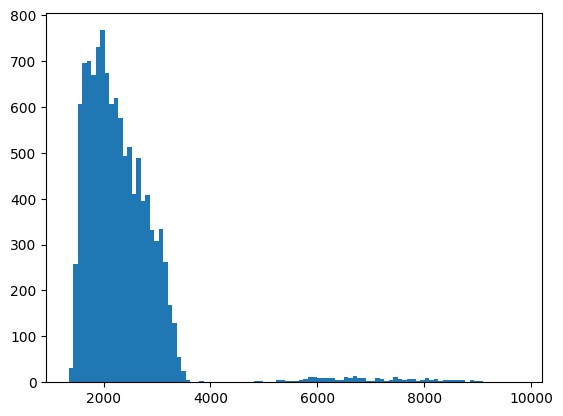

In [57]:
plt.hist(len_list, bins=100)
plt.show()

## Merge

In [40]:
question_co_flatten = [item for sublist in question_co_grouped_list for item in sublist]
answer_co_flatten = [item for sublist in answer_co_grouped_list for item in sublist]

question_squad_flatten = [item for sublist in question_squad_grouped for item in sublist]
answer_squad_flatten = [item for sublist in answer_squad_grouped for item in sublist]

corpus = story_list + question_co_flatten + answer_co_flatten +\
         article_web_list + question_web_list + answer_web_list +\
         article_wiki_list + question_wiki_list + answer_wiki_list +\
         context_squad_list + question_squad_flatten + answer_squad_flatten

print(len("".join(story_list))//1000000)
print(len("".join(question_co_flatten + answer_co_flatten))//1000000)
print(len("".join(article_web_list))//1000000)
print(len("".join(question_web_list + answer_web_list))//1000000)
print(len("".join(article_wiki_list))//1000000)
print(len("".join(question_wiki_list + answer_wiki_list))//1000000)
print(len("".join(context_squad_list))//1000000)
print(len("".join(question_squad_flatten + answer_squad_flatten))//1000000)
print(len("".join(corpus))//1000000)

11
4
233
6
207
5
14
6
490


In [ ]:
tokenizer = TokenizerBPE(corpus, 32000, lowercase=True)
tokenizer.destroy_hash()
pkl.dump(tokenizer, open("tokenizers/tokenizer_superQA_bigger_24k.pkl", "wb"))

Lowercasing corpus


  0%|          | 0/716438 [00:00<?, ?it/s]

## Tokenize Corpus

In [ ]:
tokenizer = pkl.load(open("tokenizers/tokenizer_superQA_bigger_24k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>","<pad>"])

In [8]:
def fused_sqa(story_list, question_grouped_list, answer_grouped_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    rcw = re.compile(r"\s+")

    corpus_list = []
    for story, question_list, answer_list in tqdm(list(zip(story_list, question_grouped_list, answer_grouped_list))):
        story = story.replace("\n", " ").replace("\r", " ")
        story = rcw.sub(" ", story).strip()
        sqa = [sos, normalize_to_ascii(story).lower()]
        for question, answer in zip(question_list, answer_list):
            question = question.replace("\n", " ").replace("\r", " ")
            question = rcw.sub(" ", question).strip()
            answer = answer.replace("\n", " ").replace("\r", " ")
            answer = rcw.sub(" ", answer).strip()
            sqa.append(q)
            sqa.append(normalize_to_ascii(question).lower())
            sqa.append(a)
            sqa.append(normalize_to_ascii(answer).lower())
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

In [9]:
def fused_qa(question_list, answer_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"
    rcw = re.compile(r"\s+")

    corpus_list = []
    for question, answer in tqdm(list(zip(question_list, answer_list))):
        question = question.replace("\n", " ").replace("\r", " ")
        question = rcw.sub(" ", question).strip()
        answer = answer.replace("\n", " ").replace("\r", " ")
        answer = rcw.sub(" ", answer).strip()
        qa = [sos, q, normalize_to_ascii(question), a, normalize_to_ascii(answer), eos]
        corpus_list.extend(qa)
        
    return "".join(corpus_list).lower()

In [10]:
def fused_article(corpus_list):
    sos = "<s>"
    eos = "</s>"

    rcw = re.compile(r"\s+")

    corpus_padded_list = []
    for line in corpus_list:
        line = line.replace("\n", " ").replace("\r", " ")
        line = rcw.sub(" ", line).strip()
        line = [sos, normalize_to_ascii(line).lower(), eos]
        corpus_padded_list.extend(line)
    
    return "".join(corpus_padded_list)

### Fuse CoQA

In [176]:
fused = fused_sqa(story_list, question_co_grouped_list, answer_co_grouped_list)
corpus_encoded = [tokenizer.encode(line.lower()) for line in tqdm(fused)]

pkl.dump(corpus_encoded, open('corpus/corpus_coqa_sqa_24k', 'wb'))

  0%|          | 0/7199 [00:00<?, ?it/s]

  0%|          | 0/7199 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Fuse Web

In [183]:
fused = fused_qa(question_web_list, answer_web_list)
corpus_encoded = tokenizer.encode(fused, verbose=True)

pkl.dump(corpus_encoded, open('corpus/corpus_web_qa_24k', 'wb'))

  0%|          | 0/76496 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

In [11]:
fused = fused_article(article_web_list)
corpus_encoded = tokenizer.encode(fused.lower(), verbose=True)

pkl.dump(corpus_encoded, open('corpus/corpus_web_article_24k', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Fuse Wiki

In [186]:
fused = fused_qa(question_wiki_list, answer_wiki_list)
corpus_encoded = tokenizer.encode(fused)

pkl.dump(corpus_encoded, open('corpus/corpus_wiki_qa_24k', 'wb'))

  0%|          | 0/61888 [00:00<?, ?it/s]

In [ ]:
fused = fused_article(article_wiki_list)
corpus_encoded = tokenizer.encode(fused.lower(), verbose=True)

pkl.dump(corpus_encoded, open('corpus/corpus_wiki_article_24k', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

### Fuse Sqad

In [ ]:
fused = fused_sqa(context_squad_list, question_squad_grouped, answer_squad_grouped)
corpus_encoded = [tokenizer.encode(line.lower()) for line in tqdm(fused)]

pkl.dump(corpus_encoded, open('corpus/corpus_sqad_sqa_24k', 'wb'))

  0%|          | 0/19035 [00:00<?, ?it/s]

  0%|          | 0/19035 [00:00<?, ?it/s]

## Analysis and Padding

In [ ]:
def pad_corpus(corpus, max_length, tokenizer):
    pad_token = tokenizer.token_to_idx["<pad>"]
    padded_corpus = []
    for line in tqdm(corpus):
        if line.shape[1] < max_length:
            padding = tf.repeat(tf.constant([[pad_token]]), max_length - line.shape[1], axis=1)
            padded_line = tf.concat([line, padding], axis=1)
        else:
            padded_line = line[:, :max_length]
        padded_corpus.append(padded_line)
    return tf.concat(padded_corpus, axis=0)

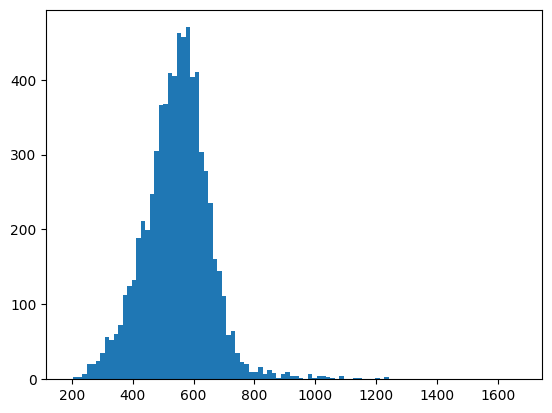

In [ ]:
corpus_encoded = pkl.load(open('corpus/corpus_coqa_sqa_24k', 'rb'))

len_list = [line.shape[1] for line in corpus_encoded]
plt.hist(len_list, bins=100)
plt.show()

In [ ]:
corpus_padded = pad_corpus(corpus_encoded, 768, tokenizer)
pkl.dump(corpus_padded, open('corpus/corpus_coqa_sqa_24k_padded', 'wb'))

  0%|          | 0/7199 [00:00<?, ?it/s]

In [ ]:
corpus_padded.shape

TensorShape([7199, 768])

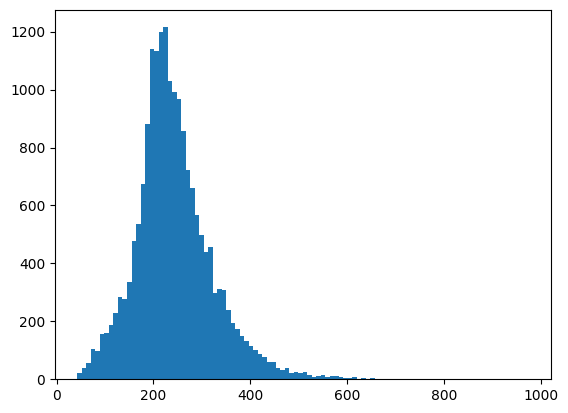

In [ ]:
corpus_encoded = pkl.load(open('corpus/corpus_sqad_sqa_24k', 'rb'))


len_list = [line.shape[1] for line in corpus_encoded]
plt.hist(len_list, bins=100)
plt.show()

In [ ]:
corpus_padded = pad_corpus(corpus_encoded, 768, tokenizer)
pkl.dump(corpus_padded, open('corpus/corpus_squad_sqa_24k_padded', 'wb'))

  0%|          | 0/19035 [00:00<?, ?it/s]

## 